In [20]:
import requests

def extract_cifar_data(url, filename="cifar.tar.gz"):
    """A function for extracting the CIFAR-100 dataset and storing it as a gzipped file
    
    Arguments:
    url      -- the URL where the dataset is hosted
    filename -- the full path where the dataset will be written
    
    """
    
    # Todo: request the data from the data url
    # Hint: use `requests.get` method
    r = requests.get(url)
    with open(filename, "wb") as file_context:
        file_context.write(r.content)
    return

In [21]:
extract_cifar_data("https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz")     

In [22]:
import tarfile

with tarfile.open("cifar.tar.gz", "r:gz") as tar:
    tar.extractall()

In [23]:
import pickle

with open("./cifar-100-python/meta", "rb") as f:
    dataset_meta = pickle.load(f, encoding='bytes')

with open("./cifar-100-python/test", "rb") as f:
    dataset_test = pickle.load(f, encoding='bytes')

with open("./cifar-100-python/train", "rb") as f:
    dataset_train = pickle.load(f, encoding='bytes')

In [24]:
# Feel free to explore the datasets

dataset_train.keys()

dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])

In [25]:
32*32*3

3072

In [26]:
import numpy as np

# Each 1024 in a row is a channel (red, green, then blue)
row = dataset_train[b'data'][0]
red, green, blue = row[0:1024], row[1024:2048], row[2048:]

# Each 32 items in the channel are a row in the 32x32 image
red = red.reshape(32,32)
green = green.reshape(32,32)
blue = blue.reshape(32,32)

# Combine the channels into a 32x32x3 image!
combined = np.dstack((red,green,blue))

In [27]:
# All in one:
test_image = np.dstack((
    row[0:1024].reshape(32,32),
    row[1024:2048].reshape(32,32),
    row[2048:].reshape(32,32)
))

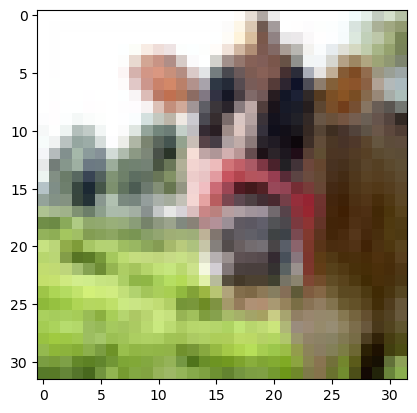

In [28]:
import matplotlib.pyplot as plt
plt.imshow(test_image);

In [29]:
dataset_train[b'fine_labels'][0]

19

In [30]:
print(dataset_meta[b'fine_label_names'][19])

b'cattle'


In [31]:
n = 0
print(dataset_meta[b'fine_label_names'][dataset_train[b'fine_labels'][n]])

b'cattle'


In [32]:
print(dataset_train[b'filenames'][0])

b'bos_taurus_s_000507.png'


In [33]:
plt.imsave("file.png", test_image)

In [34]:
import pandas as pd

# Filter the dataset_train and dataset_meta objects to find the label numbers for Bicycle and Motorcycles

bicycle_label = None
motorcycle_label = None

# Looping through the label names to find the indices for Bicycle and Motorcycle
for i in range(len(dataset_meta[b'fine_label_names'])):
    label = dataset_meta[b'fine_label_names'][i]
    if label == b'bicycle':
        bicycle_label = i
    if label == b'motorcycle':
        motorcycle_label = i

print("Bicycle label number:", bicycle_label)
print("Motorcycle label number:", motorcycle_label)

Bicycle label number: 8
Motorcycle label number: 48


In [35]:
#Construct the dataframe
df_train = pd.DataFrame({
    "filenames": dataset_train[b'filenames'],
    "labels": dataset_train[b'fine_labels'],
    "row": range(len(dataset_train[b'filenames']))
})

# Drop all rows from df_train where label is not 8 or 48
df_train = df_train[(df_train["labels"] == 8) | (df_train["labels"] == 48)]

# Decode df_train.filenames so they are regular strings
df_train["filenames"] = df_train["filenames"].apply(
    lambda x: x.decode("utf-8")
)


df_test = pd.DataFrame({
    "filenames": dataset_test[b'filenames'],
    "labels": dataset_test[b'fine_labels'],
    "row": range(len(dataset_test[b'filenames']))
})

# Drop all rows from df_test where label is not 8 or 48
df_test = df_test[(df_test["labels"] == 8) | (df_test["labels"] == 48)]

# Decode df_test.filenames so they are regular strings
df_test["filenames"] = df_test["filenames"].apply(
    lambda x: x.decode("utf-8")
)

In [36]:
!mkdir ./train
!mkdir ./test

mkdir: cannot create directory ‘./train’: File exists
mkdir: cannot create directory ‘./test’: File exists


In [37]:
import numpy as np
import matplotlib.pyplot as plt

def save_images(df, folder, dataset):
    for index, row in df.iterrows():
        # Grab the image data in row-major form
        img = dataset[b'data'][row['row']]
        
        # Consolidated stacking/reshaping from earlier
        target = np.dstack((
            img[0:1024].reshape(32,32),
            img[1024:2048].reshape(32,32),
            img[2048:].reshape(32,32)
        ))
        
        # Save the image
        plt.imsave(folder + '/' + row['filenames'], target)
    
    # Return any signal data you want for debugging
    return

# Save ALL images using the save_images function
save_images(df_train, './train', dataset_train)
save_images(df_test, './test', dataset_test)

In [38]:
import sagemaker
from sagemaker import get_execution_role

bucket= sagemaker.Session().default_bucket()
print("Default Bucket: {}".format(bucket))

region = sagemaker.Session().boto_region_name
print("AWS Region: {}".format(region))

role = get_execution_role()
print("RoleArn: {}".format(role))

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
Default Bucket: sagemaker-us-east-1-585531408529
AWS Region: us-east-1
RoleArn: arn:aws:iam::585531408529:role/service-role/AmazonSageMaker-ExecutionRole-20240809T010631


In [39]:
import os

os.environ["DEFAULT_S3_BUCKET"] = bucket
!aws s3 sync ./train s3://${DEFAULT_S3_BUCKET}/train/
!aws s3 sync ./test s3://${DEFAULT_S3_BUCKET}/test/

upload: train/bicycle_s_000038.png to s3://sagemaker-us-east-1-585531408529/train/bicycle_s_000038.png
upload: train/bicycle_s_000051.png to s3://sagemaker-us-east-1-585531408529/train/bicycle_s_000051.png
upload: train/bicycle_s_000017.png to s3://sagemaker-us-east-1-585531408529/train/bicycle_s_000017.png
upload: train/bicycle_s_000021.png to s3://sagemaker-us-east-1-585531408529/train/bicycle_s_000021.png
upload: train/bicycle_s_000039.png to s3://sagemaker-us-east-1-585531408529/train/bicycle_s_000039.png
upload: train/bicycle_s_000159.png to s3://sagemaker-us-east-1-585531408529/train/bicycle_s_000159.png
upload: train/bicycle_s_000043.png to s3://sagemaker-us-east-1-585531408529/train/bicycle_s_000043.png
upload: train/bicycle_s_000066.png to s3://sagemaker-us-east-1-585531408529/train/bicycle_s_000066.png
upload: train/bicycle_s_000099.png to s3://sagemaker-us-east-1-585531408529/train/bicycle_s_000099.png
upload: train/bicycle_s_000235.png to s3://sagemaker-us-east-1-5855314085

In [40]:
def to_metadata_file(df, prefix):
    df["s3_path"] = df["filenames"]
    df["labels"] = df["labels"].apply(lambda x: 0 if x==8 else 1)
    return df[["row", "labels", "s3_path"]].to_csv(
        f"{prefix}.lst", sep="\t", index=False, header=False
    )
    
to_metadata_file(df_train.copy(), "train")
to_metadata_file(df_test.copy(), "test")

In [41]:
import boto3

# Upload files
boto3.Session().resource('s3').Bucket(
    bucket).Object('train.lst').upload_file('./train.lst')
boto3.Session().resource('s3').Bucket(
    bucket).Object('test.lst').upload_file('./test.lst')

In [42]:
from sagemaker import image_uris

# Use the image_uris function to retrieve the latest 'image-classification' image 
algo_image = image_uris.retrieve('image-classification', region)
s3_output_location = f"s3://{bucket}/models/image_model"

In [43]:
img_classifier_model = sagemaker.estimator.Estimator(
    image_uri=algo_image,
    role=role,
    instance_count=1,
    instance_type='ml.p3.2xlarge',
    output_path=s3_output_location,
    sagemaker_session=sagemaker.Session()
)

In [44]:
img_classifier_model.set_hyperparameters(
    image_shape='3,32,32', 
    num_classes=2, 
    num_training_samples= len(df_train)
)

In [45]:
from sagemaker.debugger import Rule, rule_configs
from sagemaker.session import TrainingInput
model_inputs = {
        "train": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/train/",
            content_type="application/x-image"
        ),
        "validation": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/test/",
            content_type="application/x-image"
        ),
        "train_lst": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/train.lst",
            content_type="application/x-image"
        ),
        "validation_lst": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/test.lst",
            content_type="application/x-image"
        )
}

In [46]:
## TODO: train your model
img_classifier_model.fit(inputs=model_inputs)

INFO:sagemaker:Creating training-job with name: image-classification-2024-08-09-03-40-48-474


2024-08-09 03:40:48 Starting - Starting the training job...
2024-08-09 03:40:48 Pending - Training job waiting for capacity......
2024-08-09 03:42:00 Pending - Preparing the instances for training...
2024-08-09 03:42:41 Downloading - Downloading input data...
2024-08-09 03:43:01 Downloading - Downloading the training image..................
2024-08-09 03:46:18 Training - Training image download completed. Training in progress....Docker entrypoint called with argument(s): train
Running default environment configuration script
Nvidia gpu devices, drivers and cuda toolkit versions (only available on hosts with GPU):
Fri Aug  9 03:46:40 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile U

In [47]:
from sagemaker.model_monitor import DataCaptureConfig

data_capture_config = DataCaptureConfig(
    ## TODO: Set config options
    enable_capture=True,
    sampling_percentage=100,
    destination_s3_uri=f"s3://{bucket}/data_capture"
)

In [48]:
deployment = img_classifier_model.deploy(
    ## TODO: fill in deployment options
    initial_instance_count=1,
    instance_type='ml.m5.xlarge',
    data_capture_config=data_capture_config
    )

endpoint = deployment.endpoint_name
print(endpoint)

INFO:sagemaker:Creating model with name: image-classification-2024-08-09-03-50-35-740
INFO:sagemaker:Creating endpoint-config with name image-classification-2024-08-09-03-50-35-740
INFO:sagemaker:Creating endpoint with name image-classification-2024-08-09-03-50-35-740


-------------!image-classification-2024-08-09-03-50-35-740


In [88]:
from sagemaker.predictor import Predictor

predictor = Predictor(endpoint_name=endpoint)

In [89]:
from sagemaker.serializers import IdentitySerializer
import base64

predictor.serializer = IdentitySerializer("image/png")
with open("./test/bicycle_s_000059.png", "rb") as f:
    payload = f.read()

    
inference = predictor.predict(payload)

print(inference)

b'[0.00891333818435669, 0.9910866618156433]'


In [90]:
print(inference)

b'[0.00891333818435669, 0.9910866618156433]'


In [91]:
{
    "inferences": [0.00891333818435669, 0.9910866618156433], # Output of predictor.predict
    "s3_key": "test/bicycle_s_000059.png", # Source data S3 key
    "s3_bucket": "sagemaker-us-east-1-585531408529", # Source data S3 bucket
    "image_data": ""  # base64 encoded string containing the image data
}

{'inferences': [0.00891333818435669, 0.9910866618156433],
 's3_key': 'test/bicycle_s_000059.png',
 's3_bucket': 'sagemaker-us-east-1-585531408529',
 'image_data': ''}

In [92]:
{
  "image_data": "",
  "s3_bucket": "sagemaker-us-east-1-585531408529",
  "s3_key": "test/bicycle_s_000059.png"
}

{'image_data': '',
 's3_bucket': 'sagemaker-us-east-1-585531408529',
 's3_key': 'test/bicycle_s_000059.png'}

In [93]:
import json
import boto3
import base64

s3 = boto3.client('s3')

def lambda_handler(event, context):
    """A function to serialize target data from S3"""
    
    # Get the s3 address from the Step Function event input
    key = event['s3_key'] ## TODO: fill in
    bucket = event['s3_bucket'] ## TODO: fill in
    
    # Download the data from s3 to /tmp/image.png
    ## TODO: fill in
    s3.download_file(bucket, key, '/tmp/image.png')
    
    # We read the data from a file
    with open("/tmp/image.png", "rb") as f:
        image_data = base64.b64encode(f.read())

    # Pass the data back to the Step Function
    print("Event:", event.keys())
    return {
        'statusCode': 200,
        'body': {
            "image_data": image_data,
            "s3_bucket": bucket,
            "s3_key": key,
            "inferences": []
        }
    }

In [94]:
import json
import sagemaker
import base64
from sagemaker.serializers import IdentitySerializer

# Fill this in with the name of your deployed model
ENDPOINT = endpoint ## TODO: fill in

def lambda_handler(event, context):

    # Decode the image data
    image = base64.b64decode(event['image_data'])  ## TODO: fill in)

    # Instantiate a Predictor
    predictor = sagemaker.predictor.Predictor(endpoint_name=ENDPOINT) ## TODO: fill in

    # For this model the IdentitySerializer needs to be "image/png"
    predictor.serializer = IdentitySerializer("image/png")
    
    # Make a prediction:
    inferences = predictor.predict(image) ## TODO: fill in
    
    # We return the data back to the Step Function    
    event["inferences"] = inferences.decode('utf-8')
    return {
        'statusCode': 200,
        'body': json.dumps(event)
    }

In [95]:
import json


THRESHOLD = .93


def lambda_handler(event, context):
    
    # Grab the inferences from the event
    
    inferences = json.loads(event['inferences']) ## TODO: fill in
    
    # Check if any values in our inferences are above THRESHOLD
    meets_threshold = any(i > THRESHOLD for i in inferences) ## TODO: fill in
    
    # If our threshold is met, pass our data back out of the
    # Step Function, else, end the Step Function with an error
    if meets_threshold:
        pass
    else:
        raise("THRESHOLD_CONFIDENCE_NOT_MET")

    return {
        'statusCode': 200,
        'body': json.dumps(event)
    }

In [96]:
import random
import boto3
import json

def generate_test_case():
    # Setup s3 in boto3
    s3 = boto3.resource('s3')
    
    # Randomly pick from sfn or test folders in our bucket
    bucket_name = "sagemaker-us-east-1-585531408529"
    
    objects = s3.Bucket(bucket_name).objects.filter(Prefix="test/")
    object_keys = [x.key for x in objects]
    
    if not object_keys:
        raise ValueError("No objects found in the specified S3 folder.")
    
    # Grab any random object key from that folder!
    obj = random.choice(object_keys)
    
    return json.dumps({
        "image_data": "",
        "s3_bucket": bucket_name,
        "s3_key": obj
    })

print(generate_test_case())


{"image_data": "", "s3_bucket": "sagemaker-us-east-1-585531408529", "s3_key": "test/velocipede_s_001379.png"}


In [97]:
import boto3
from sagemaker.s3 import S3Downloader

# Initialize the S3 client
s3_client = boto3.client('s3')

# Define your bucket name
bucket_name = "sagemaker-us-east-1-585531408529"  # Replace with your actual bucket name

# List objects in the data_capture folder
response = s3_client.list_objects_v2(Bucket=bucket_name, Prefix="data_capture/")

# Extract the paths
paths = [content['Key'] for content in response.get('Contents', [])]

# Print the available paths
print("Available paths:", paths)

# Choose a path to download (you can choose the most recent one or any specific one)
if paths:
    data_path = f"s3://{bucket_name}/{paths[0]}"  # Replace with the desired path
    print("Downloading data from:", data_path)
    
    # Download the data to a local directory
    S3Downloader.download(data_path, "captured_data")
else:
    print("No data found in the data_capture folder.")


Available paths: ['data_capture/image-classification-2024-08-09-03-50-35-740/AllTraffic/2024/08/09/03/57-38-953-f712bfa7-4e4e-4ba7-996d-f55699dfa907.jsonl']


In [98]:
from sagemaker.s3 import S3Downloader

# In S3 your data will be saved to a datetime-aware path
# Find a path related to a datetime you're interested in
data_path = "s3://sagemaker-us-east-1-585531408529/data_capture/image-classification-2024-08-09-03-50-35-740/AllTraffic/2024/08/09/03/57-38-953-f712bfa7-4e4e-4ba7-996d-f55699dfa907.jsonl"

S3Downloader.download(data_path, "captured_data")

# Feel free to repeat this multiple times and pull in more data

['captured_data/57-38-953-f712bfa7-4e4e-4ba7-996d-f55699dfa907.jsonl']

In [99]:
!pip install jsonlines
import jsonlines

In [100]:
import os

# List the file names we downloaded
file_handles = os.listdir("./captured_data")

# Dump all the data into an array
json_data = []
for jsonl in file_handles:
    with jsonlines.open(f"./captured_data/{jsonl}") as f:
        json_data.append(f.read())

In [101]:
# Define how we'll get our data
def simple_getter(obj):
    inferences = obj["captureData"]["endpointOutput"]["data"]
    timestamp = obj["eventMetadata"]["inferenceTime"]
    return json.loads(inferences), timestamp

simple_getter(json_data[0])

([0.00891333818435669, 0.9910866618156433], '2024-08-09T03:57:38Z')

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


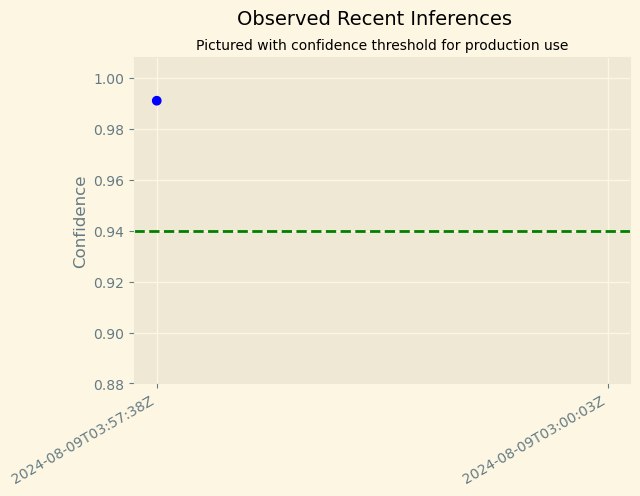

In [102]:
import matplotlib.pyplot as plt

# Populate the data for the x and y axis
x = []
y = []
for obj in json_data:
    inference, timestamp = simple_getter(obj)
    
    y.append(max(inference))
    x.append(timestamp)

# Todo: here is an visualization example, take some time to build another visual that helps monitor the result
# Plot the data

plt.scatter(x, y, c=['r' if k<.94 else 'b' for k in y ])
plt.axhline(y=0.94, color='g', linestyle='--')
plt.ylim(bottom=.88)

# Add labels
plt.ylabel("Confidence")
plt.suptitle("Observed Recent Inferences", size=14)
plt.title("Pictured with confidence threshold for production use", size=10)

# Give it some pizzaz!
plt.style.use("Solarize_Light2")
plt.gcf().autofmt_xdate()

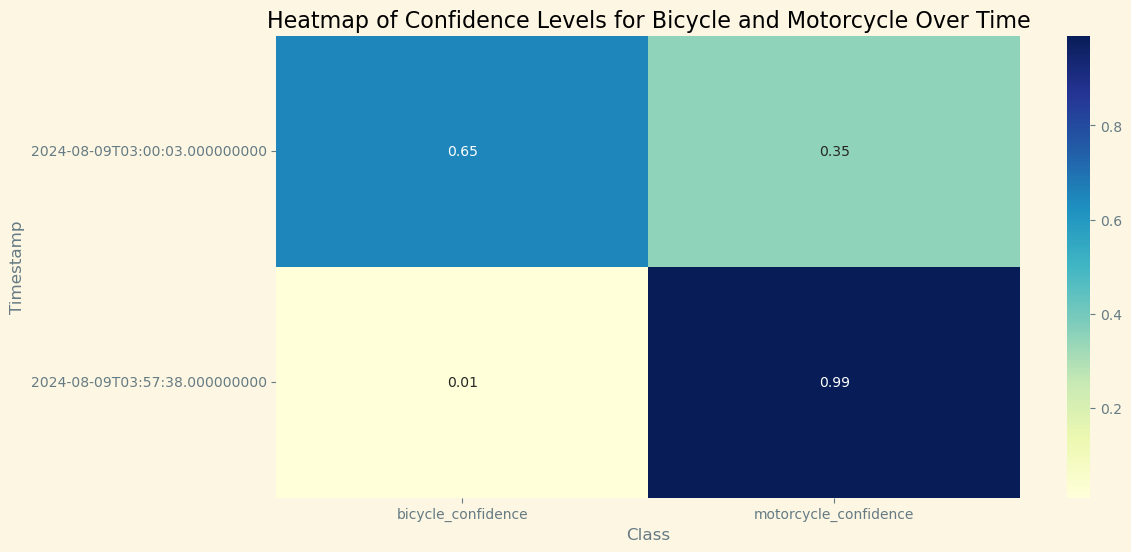

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Extract the inferences and timestamps
bicycle_confidences = []
motorcycle_confidences = []
timestamps = []

for obj in json_data:
    inferences, timestamp = simple_getter(obj)
    bicycle_confidences.append(inferences[0])
    motorcycle_confidences.append(inferences[1])
    timestamps.append(timestamp)

# Create a DataFrame
df = pd.DataFrame({
    'timestamp': pd.to_datetime(timestamps),
    'bicycle_confidence': bicycle_confidences,
    'motorcycle_confidence': motorcycle_confidences
})

# Pivot the DataFrame for heatmap
df_pivot = df.melt(id_vars=['timestamp'], value_vars=['bicycle_confidence', 'motorcycle_confidence'], var_name='class', value_name='confidence')

# Plot the heatmap
plt.figure(figsize=(12, 6))
heatmap_data = df_pivot.pivot_table(index="timestamp", columns="class", values="confidence")
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt=".2f")

# Add labels and titles
plt.xlabel("Class")
plt.ylabel("Timestamp")
plt.title("Heatmap of Confidence Levels for Bicycle and Motorcycle Over Time")

# Show the plot
plt.show()
